## Checkpoint 2 - Data Science 

### Cassio Valezzi | 551059
### Lucca Sabatini | 98169
### Victor Nuzzi   | 98209 

### Importando e lendo arquivo

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataApple = pd.read_csv("apple_quality.csv")
display(dataApple)

ModuleNotFoundError: No module named 'seaborn'

### Descrição dos dados e vendo cada tipo

In [25]:
display(dataApple.describe(include="all"))
display(dataApple.info())

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4001,4000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4001,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.491590483,good
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2004
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,NaN,NaN
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,NaN,NaN
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,NaN,NaN
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,NaN,NaN
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,NaN,NaN
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


None

### Graficos de cada item em formato de tabela

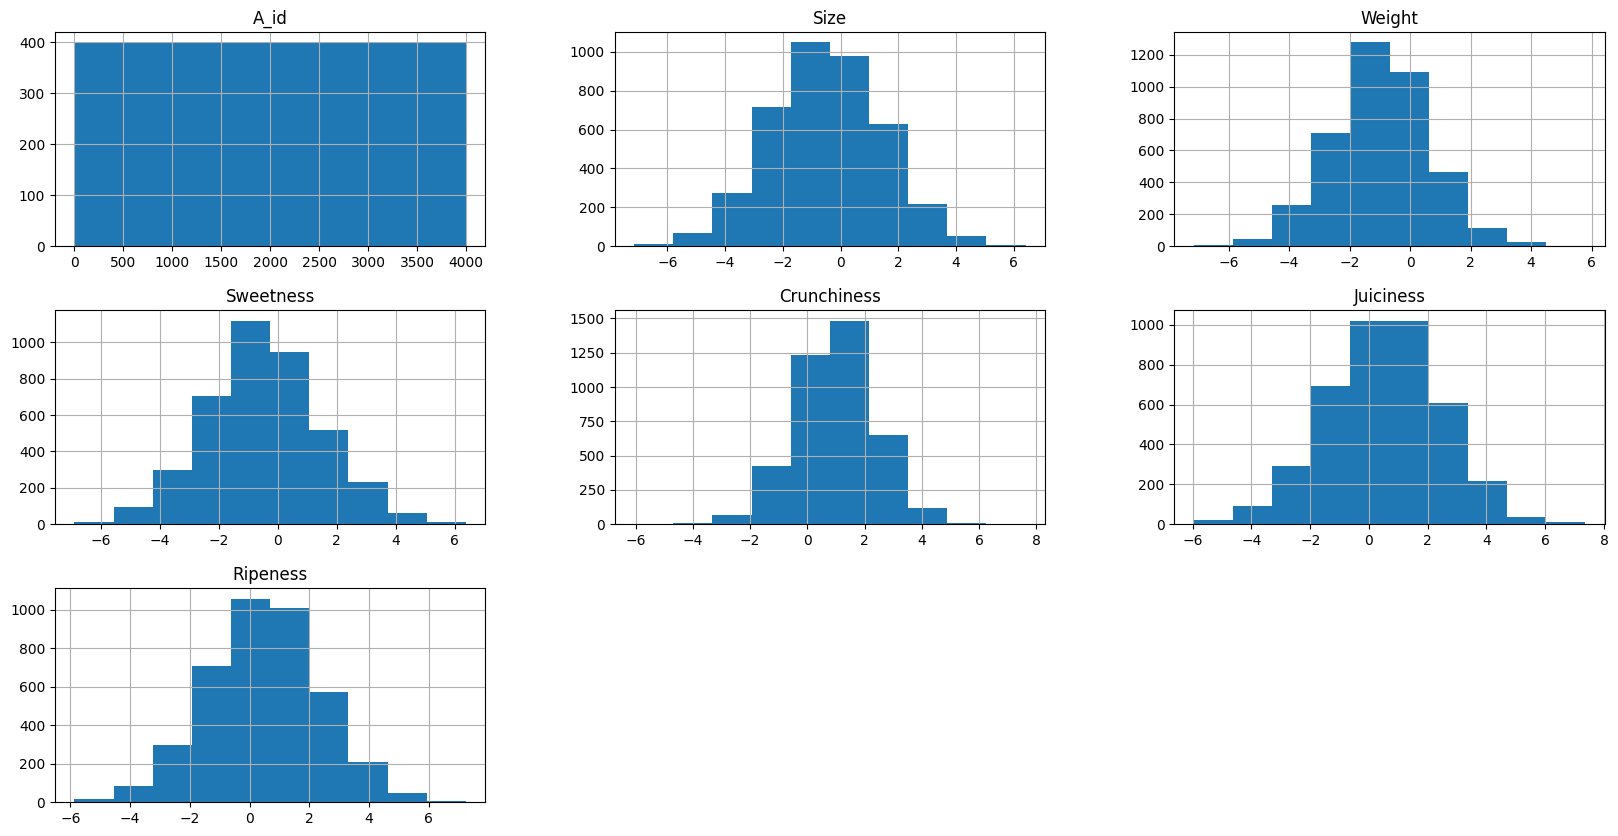

In [27]:
plt.rcParams['figure.figsize']=[20,10]
dataApple.hist()
plt.show()

### Graficos de cada item em formato de onda

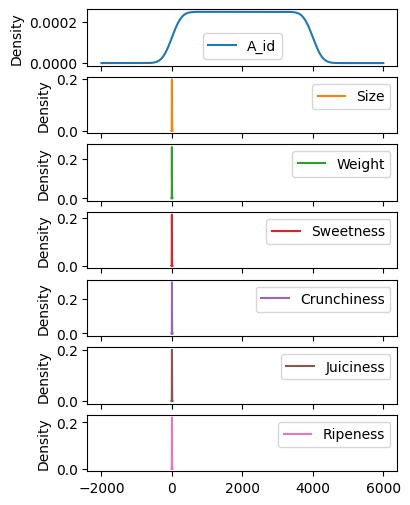

In [31]:
plt.rcParams['figure.figsize']=[4,6]
dataApple.plot(kind='density',subplots=True,sharex=True)
plt.show()

### Box plot

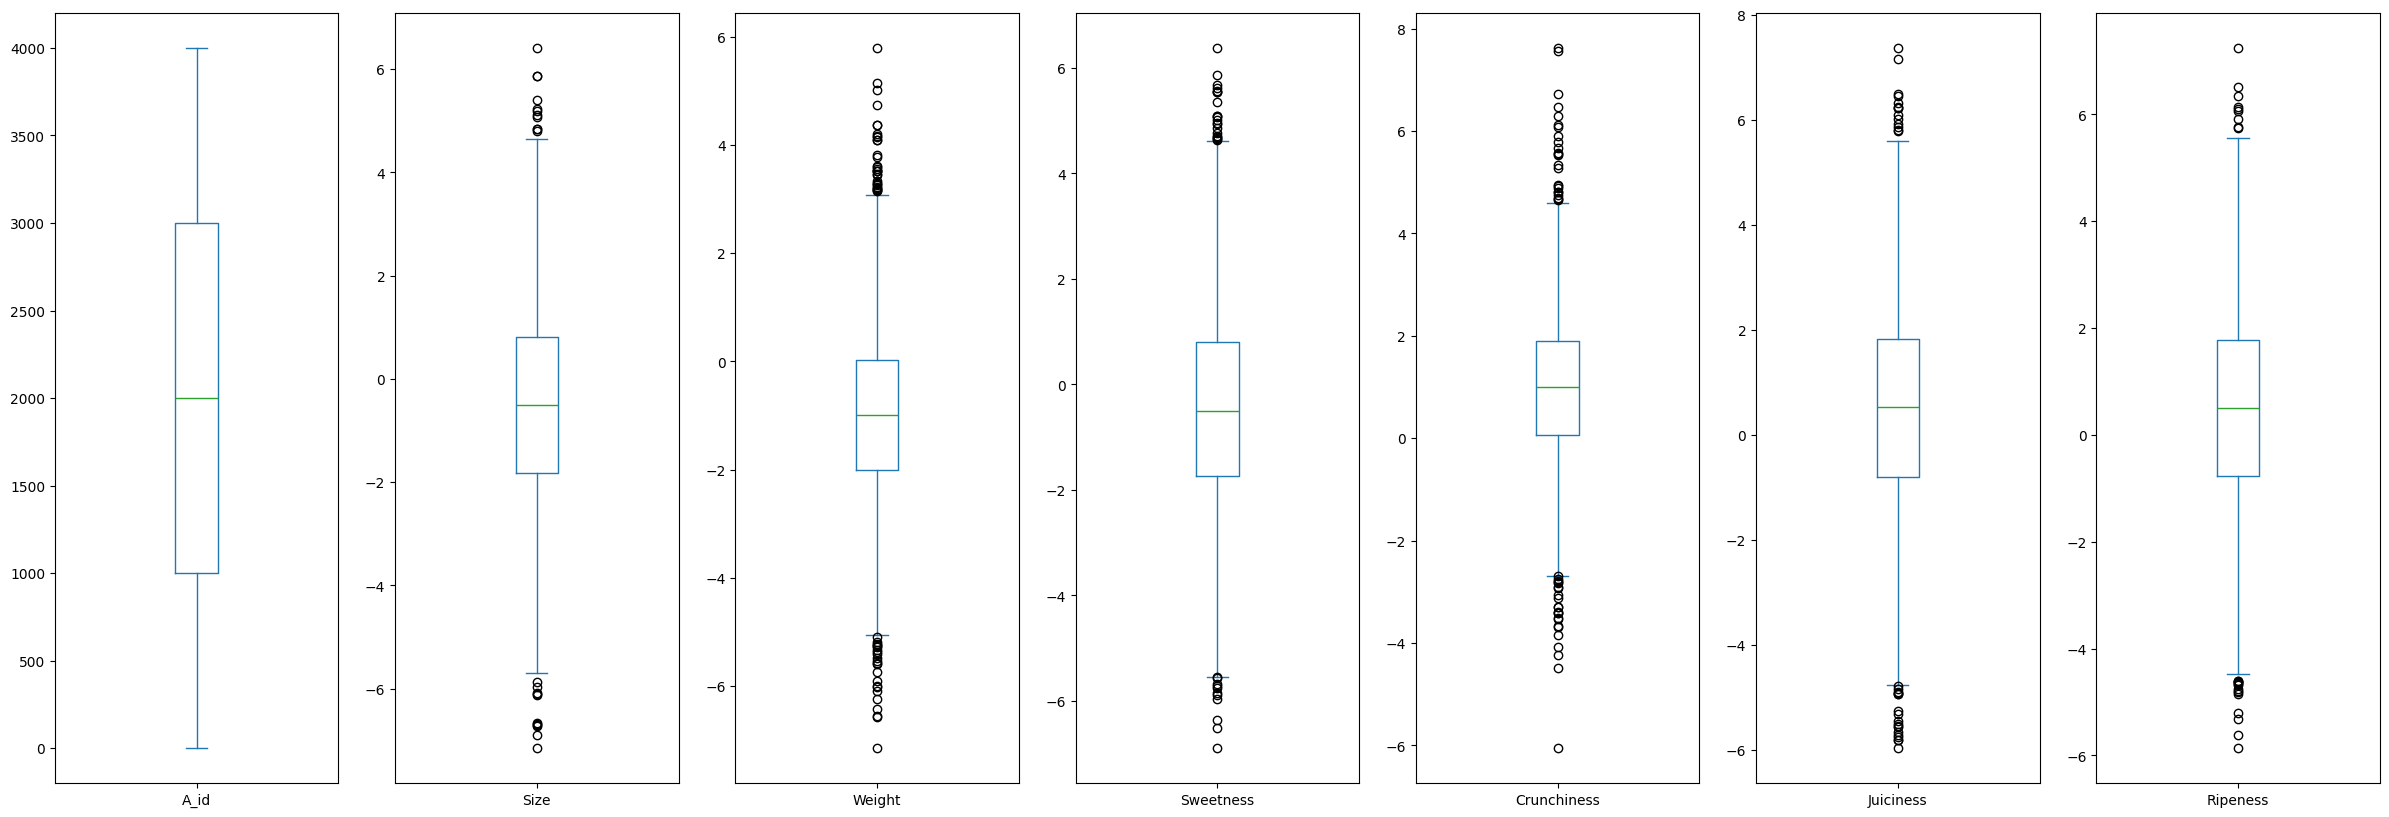

In [30]:
plt.rcParams['figure.figsize']=[30,10]
dataApple.plot(kind='box',subplots=True,sharex=False)
plt.show()

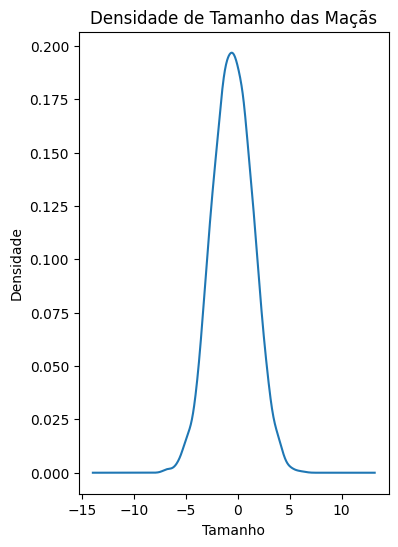

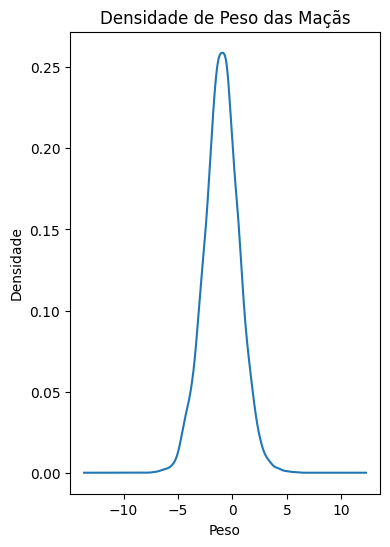

In [34]:
#Tamanho
plt.rcParams['figure.figsize'] = [4, 6]
dataApple['Size'].plot(kind='density')
plt.title('Densidade de Tamanho das Maçãs')
plt.xlabel('Tamanho')
plt.ylabel('Densidade')
plt.show()

#------------------------------

#Peso
plt.rcParams['figure.figsize'] = [4, 6]
dataApple['Weight'].plot(kind='density')
plt.title('Densidade de Peso das Maçãs')
plt.xlabel('Peso')
plt.ylabel('Densidade')
plt.show()

## Regreção linear

In [7]:

sns.set_theme(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="total_bill", y="tip", data=tips,
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)

ModuleNotFoundError: No module named 'seaborn'